# I) Summary

**DISCLAIMER**: We will use a simplier version of the LeNet-5 than the one in the [paper](http://yann.lecun.com/exdb/publis/pdf/lecun-01a.pdf). (For example, computation on average pooling layers described in the paper are slightly more complex than usual).

LeNet-5 has:

- 2 Convolutional layers.
- 3 Fully connected layers.
- 2 Average pooling layers.
- Tanh as activation function for hidden layer.
- Softmax as activation function for output layer.
- 60000 trainable parameters.
- Cross-entropy as cost function
- Gradient descent as optimizer.

LeNet-5 is:

- trained on MNIST dataset (60000 training examples).
- trained over 20 epoch.

LeNet-5 is expected to:
- converge after 10-12 epoch.
- have an error rate of 0.95% on test set. (Using accuracy as mettric)

![](../img/legend.png)

![](../img/lenet5-model.png)

# II) Implementation

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
%matplotlib inline

## a) Loading dataset

In [66]:
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.mnist.load_data()
X_val, y_val = X_train[55000:, ..., np.newaxis], y_train[55000:]
X_train, y_train = X_train[:55000, ..., np.newaxis], y_train[:55000]
X_test =  X_test[..., np.newaxis]

print("Image Shape: {}".format(X_train[0].shape), end = '\n\n')
print("Training Set:   {} samples".format(len(X_train)))
print("Validation Set:   {} samples".format(len(X_val)))
print("Test Set:       {} samples".format(len(X_test)))

Image Shape: (28, 28, 1)

Training Set:   55000 samples
Validation Set:   5000 samples
Test Set:       10000 samples


## b) Preprocessing

We need to:

- reshape the image into a 32x32x1 shape.
- normalize the dataset.

If your ~/.keras/keras.json has the following: 

- <b>"image_data_format": "channels_first"</b>.

Change it to "<b>channels_last</b>".

In [67]:
# Pad images with 0s
X_train = np.pad(X_train, ((0,0),(2,2),(2,2),(0,0)), 'constant')
X_val = np.pad(X_val, ((0,0),(2,2),(2,2),(0,0)), 'constant')
X_test = np.pad(X_test, ((0,0),(2,2),(2,2),(0,0)), 'constant')

print("Updated Image Shape for: ", end='\n\n')
print("-Training set: {}".format(X_train.shape))
print("-Validation set: {}".format(X_val.shape))
print("-Test set: {}".format(X_test.shape))

Updated Image Shape for: 

-Training set: (55000, 32, 32, 1)
-Validation set: (5000, 32, 32, 1)
-Test set: (10000, 32, 32, 1)


In [68]:
# Normalization.
X_train, X_val, X_test = X_train/float(255), X_val/float(255), X_test/float(255)
X_train -= np.mean(X_train)
X_val -= np.mean(X_val)
X_test -= np.mean(X_test)

## c) Visualization

In [69]:
def plot_example(X, y, y_pred=None):
    """
        Plots 9 examples and their associate labels.
        
        Parameters:
        -X: Training examples.
        -y: true labels.
        -y_pred: predicted labels.
    """
    # Create figure with 3 x 3 sub-plots.
    fig, axes = plt.subplots(3, 3)
    fig.subplots_adjust(hspace=0.3, wspace=0.3)
     
    X, y = X[:9, ..., 0], y[:9] 
    
    for i, ax in enumerate(axes.flat):
        # Plot image.
        ax.imshow(X[i])

        # Show true and predicted classes.
        if y_pred is None:
            xlabel = "True: {0}".format(y[i])
        else:
            xlabel = "True: {0}, Pred: {1}".format(y[i], y_pred[i])

        # Show the classes as the label on the x-axis.
        ax.set_xlabel(xlabel)
        
        # Remove ticks from the plot.
        ax.set_xticks([])
        ax.set_yticks([])
    
    # Ensure the plot is shown correctly with multiple plots in a single Notebook cell.
    plt.show()

In [70]:
def plot_example_errors(X, y, y_pred):
    """
        Plots 9 example errors and their associate true/predicted labels.
        
        Parameters:
        -X: Training examples.
        -y: true labels.
        -y_pred: predicted labels.
    
    """
    incorrect = (y != y_pred)
 
    X = X[incorrect]
    y = y[incorrect]
    y_pred = y_pred[incorrect]
    
    # Plot the first 9 images.
    plot_example(X, y, y_pred)

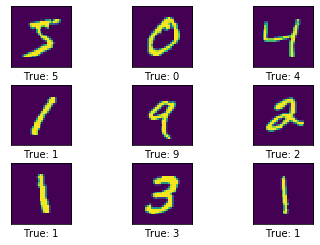

In [71]:
plot_example(X_train, y_train)

## d) Architecture build

In [72]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D, AveragePooling2D, Flatten, Dense
from tensorflow.keras.losses import CategoricalCrossentropy

In [73]:
def LeNet_5():
    model = Sequential()

    # C1: (None,32,32,1) -> (None,28,28,6).
    model.add(Conv2D(6, kernel_size=(5, 5), strides=(1, 1), activation='tanh', input_shape=(32,32,1), padding='valid'))

    # P1: (None,28,28,6) -> (None,14,14,6).
    model.add(AveragePooling2D(pool_size=(2, 2), strides=(2, 2), padding='valid'))

    # C2: (None,14,14,6) -> (None,10,10,16).
    model.add(Conv2D(16, kernel_size=(5, 5), strides=(1, 1), activation='tanh', padding='valid'))

    # P2: (None,10,10,16) -> (None,5,5,16).
    model.add(AveragePooling2D(pool_size=(2, 2), strides=(2, 2), padding='valid'))

    # Flatten: (None,5,5,16) -> (None, 400).
    model.add(Flatten())

    # FC1: (None, 400) -> (None,120).
    model.add(Dense(120, activation='tanh'))

    # FC2: (None,120) -> (None,84).
    model.add(Dense(84, activation='tanh'))

    # FC3: (None,84) -> (None,10).
    model.add(Dense(10, activation='softmax'))

    # Compile the model
    model.compile(loss='sparse_categorical_crossentropy', optimizer='sgd', metrics=['accuracy']) 
    
    return model

In [74]:
model = LeNet_5()
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 28, 28, 6)         156       
_________________________________________________________________
average_pooling2d_6 (Average (None, 14, 14, 6)         0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 10, 10, 16)        2416      
_________________________________________________________________
average_pooling2d_7 (Average (None, 5, 5, 16)          0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 400)               0         
_________________________________________________________________
dense_9 (Dense)              (None, 120)               48120     
_________________________________________________________________
dense_10 (Dense)             (None, 84)               

## e) Training the model

In [75]:
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=20)

Train on 55000 samples, validate on 5000 samples
Epoch 1/20
55000/55000 [==============================] - 29s 518us/sample - loss: 0.5951 - accuracy: 0.8439 - val_loss: 0.2478 - val_accuracy: 0.9326
Epoch 2/20
55000/55000 [==============================] - 31s 572us/sample - loss: 0.2718 - accuracy: 0.9199 - val_loss: 0.1805 - val_accuracy: 0.9520
Epoch 3/20
55000/55000 [==============================] - 33s 607us/sample - loss: 0.2089 - accuracy: 0.9384 - val_loss: 0.1470 - val_accuracy: 0.9626
Epoch 4/20
55000/55000 [==============================] - 40s 722us/sample - loss: 0.1699 - accuracy: 0.9504 - val_loss: 0.1210 - val_accuracy: 0.9664
Epoch 5/20
55000/55000 [==============================] - 43s 776us/sample - loss: 0.1429 - accuracy: 0.9583 - val_loss: 0.1059 - val_accuracy: 0.9682
Epoch 6/20
55000/55000 [==============================] - 42s 756us/sample - loss: 0.1235 - accuracy: 0.9632 - val_loss: 0.0964 - val_accuracy: 0.9736
Epoch 7/20
55000/55000 [=====================

In [76]:
# Save the model.
model.save("lenet5_model.h5")

## f) Evaluating the model

Test set error rate: 0.9837

Some correct classification:


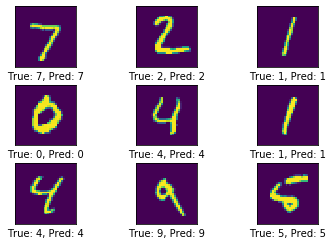


Some incorrect classification:


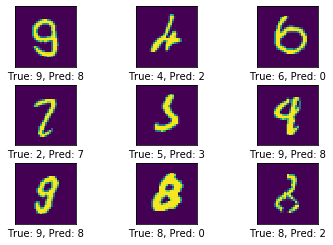


Plot of training error over 20 epochs:


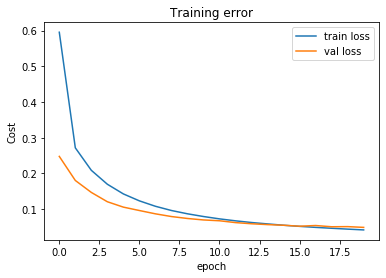

In [80]:
# Restore the model.
model = tf.keras.models.load_model('lenet5_model.h5')

# Make prediction.
predictions = model.predict(X_test)

# Retrieve predictions
y_pred = np.argmax(predictions, axis=1)

# Print test set accuracy.
print('Test set error rate: {}'.format(np.mean(y_pred == y_test)))

# Plot some examples with model predictions.
print('\nSome correct classification:')
plot_example(X_test, y_test, y_pred)

print('\nSome incorrect classification:')
plot_example_errors(X_test, y_test, y_pred)

# Plot training error.
print('\nPlot of training error over 20 epochs:')
plt.title('Training error')
plt.ylabel('Cost')
plt.xlabel('epoch')

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['train loss', 'val loss'], loc='upper right')
plt.show()

# III) Conclusion

We can conclude that:

- The test set error (accuracy) is greater than 0.95% (0.9837%).
- It seems to start converging after 10-12 epochs.